# AI Model for Predicting Sea Surface Currents 

This notebook outlines the steps to develop a CNN-LSTM hybrid model for predicting future sea surface currents.

### Importing necessary libraries

In [1]:
import xarray as xr
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Conv2D, MaxPooling2D, Flatten, LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tqdm.keras import TqdmCallback
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.callbacks import Callback

### Printing info about Sea Surace Currents Dataset

In [2]:
# Load the processed sea surface current (SSC) data
ssc_data_path = "Data/Processed_SSC_Data.nc"
ssc_ds = xr.open_dataset(ssc_data_path)

# Display the dataset structure
print(ssc_ds)
print("="*125)

<xarray.Dataset>
Dimensions:  (lat: 25, lon: 22, time: 2091)
Coordinates:
  * lat      (lat) float32 35.74 35.77 35.79 35.81 ... 36.21 36.23 36.26 36.28
  * lon      (lon) float32 13.92 13.96 14.0 14.04 ... 14.65 14.69 14.73 14.77
  * time     (time) datetime64[ns] 2021-01-01 2021-01-01T12:00:00 ... 2023-11-12
Data variables:
    u        (time, lat, lon) float64 ...
    v        (time, lat, lon) float64 ...
    stdu     (time, lat, lon) float64 ...
    stdv     (time, lat, lon) float64 ...
    cov      (time, lat, lon) float64 ...
    velo     (time, lat, lon) float64 ...
    head     (time, lat, lon) float64 ...
Attributes: (12/17)
    NC_GLOBAL.Title:                   Near-Real time Surface Ocean Velocity
    NC_GLOBAL.origin:                  BARK (measured);POZZ (measured);
    NC_GLOBAL.source:                  HF Radar Derived Surface Currents obta...
    NC_GLOBAL.history:                 08-Jun-2023 14:46:23
    NC_GLOBAL.grid_type:               REGULAR
    NC_GLOBAL.Convent

### Data Preparation 

In [3]:
# Selecting only the 'u' and 'v' variables
uv_ds = ssc_ds[['u', 'v']]

uv_ds = uv_ds.fillna(uv_ds.mean())

# Standardize the 'u' and 'v' variables
uv_mean = uv_ds.mean(dim=['time', 'lat', 'lon'])
uv_std = uv_ds.std(dim=['time', 'lat', 'lon'])

uv_standardized = (uv_ds - uv_mean) / uv_std

def create_sequences(data, sequence_length=28):
    """
    Creates sequences of data for training.
    :param data: The standardized dataset containing 'u' and 'v'.
    :param sequence_length: The number of time steps to use for each sequence.
    :return: X, y where X is a sequence of data and y is the label for each sequence.
    """
    X = []
    y = []

    # Convert data to a Dataset to an array for easier slicing
    data_array = data.to_array().transpose("time", "lat", "lon", "variable")
    print(f"Data array shape after transpose: {data_array.shape}")

    for i in range(len(data.time) - sequence_length):
        X_seq = data_array.isel(time=slice(i, i + sequence_length)).values
        y_seq = data_array.isel(time=i + sequence_length).values
        
        X.append(X_seq)
        y.append(y_seq)

    # Convert lists to numpy arrays
    X = np.array(X)
    y = np.array(y)
    
    # No need to move axes, as we already transposed data to the correct shape
    return X, y

# Prepare the data for sequence creation
X, y = create_sequences(uv_standardized)

# Information about the shapes of X and y for confirmation
print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

# Check if there are NaNs in the standardized data
assert not np.isnan(uv_standardized.to_array()).any(), "There are NaNs in the standardized data"

Data array shape after transpose: (2091, 25, 22, 2)
Shape of X: (2063, 28, 25, 22, 2)
Shape of y: (2063, 25, 22, 2)


### Model Definition

In [4]:
# Model configuration
input_shape = (28, 25, 22, 2)  # Corresponds to (sequence_length, lat, lon, channels)
conv_filters = 16  # Number of convolutional filters
kernel_size = (3, 3)  # Size of the convolutional kernel
pool_size = (2, 2)  # Pooling size
lstm_units = 64  # Number of units in the LSTM layer
dense_units = 50  # Number of units in the Dense layer
output_shape = 25 * 22 * 2  # Total number of predictions to match the y shape

# Define the model
model = Sequential([
    TimeDistributed(Conv2D(conv_filters, kernel_size, activation='relu'), input_shape=input_shape),
    TimeDistributed(MaxPooling2D(pool_size=pool_size)),
    TimeDistributed(Flatten()),
    LSTM(lstm_units, activation='tanh'),
    Dense(dense_units, activation='relu'),
    Dense(output_shape),
    tf.keras.layers.Reshape((25, 22, 2))
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 28, 23, 20, 16)   304       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 28, 11, 10, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 28, 1760)         0         
 tributed)                                                       
                                                                 
 lstm (LSTM)                 (None, 64)                467200    
                                                                 
 dense (Dense)               (None, 50)                3250      
                                                        

### Compile the Model

In [5]:
optimizer = Adam(learning_rate=0.001, clipvalue=1.0)
model.compile(optimizer=optimizer, loss='mse')

### Train the Model

In [6]:
# Define the split indices
train_split_idx = int(0.7 * len(X))  # 70% for training
val_split_idx = train_split_idx + int(0.15 * len(X))  # Additional 15% for validation

# Split the dataset
X_train, X_val, X_test = X[:train_split_idx], X[train_split_idx:val_split_idx], X[val_split_idx:]
y_train, y_val, y_test = y[:train_split_idx], y[train_split_idx:val_split_idx], y[val_split_idx:]

# Training configuration
epochs = 10
batch_size = 32

class DetailedEpochCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_loss = logs.get('val_loss')
        train_loss = logs.get('loss')
        print(f"\nEnd of epoch {epoch + 1}: Training Loss: {train_loss}, Validation Loss: {val_loss}")

# Use this custom callback along with TqdmCallback
history = model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val, y_val),
    verbose=0,  # Still turn off the default verbose output
    callbacks=[TqdmCallback(verbose=1), DetailedEpochCallback()]
)

model.save('Model_Outputs/SSC_Model.h5')

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]


End of epoch 1: Training Loss: 0.9483675360679626, Validation Loss: 0.5224029421806335

End of epoch 2: Training Loss: 0.7278046011924744, Validation Loss: 0.462975412607193

End of epoch 3: Training Loss: 0.6595052480697632, Validation Loss: 0.4379183053970337

End of epoch 4: Training Loss: 0.6250073313713074, Validation Loss: 0.4110003709793091

End of epoch 5: Training Loss: 0.5908679962158203, Validation Loss: 0.41128402948379517

End of epoch 6: Training Loss: 0.5644832849502563, Validation Loss: 0.39655056595802307

End of epoch 7: Training Loss: 0.5393831729888916, Validation Loss: 0.3834264278411865

End of epoch 8: Training Loss: 0.5197669863700867, Validation Loss: 0.3780408501625061

End of epoch 9: Training Loss: 0.5070231556892395, Validation Loss: 0.3831019103527069

End of epoch 10: Training Loss: 0.4937349259853363, Validation Loss: 0.38913694024086


## Model Evaluation

After training our Convolutional Neural Network-Long Short Term Memory (CNN-LSTM) model, it is essential to assess its performance to understand how well it has learned from the training dataset and to evaluate its ability to generalize to unseen data. This step involves calculating loss and accuracy metrics on both the validation and test datasets.

### Validation Set Evaluation

In [27]:
# Evaluate the model on the validation set
val_loss = model.evaluate(X_val, y_val, verbose=0)
print(f"Validation Loss (MSE): {val_loss:.4f}")

# Calculate Mean Absolute Error (MAE) on the validation set
val_mae = mean_absolute_error(y_val.reshape(-1, y_val.shape[-1]), val_predictions.reshape(-1, val_predictions.shape[-1]))
print(f"Validation MAE: {val_mae:.4f}")

# Generate predictions for the validation set
val_predictions = model.predict(X_val, verbose=0)

Validation Loss (MSE): 0.3891
Validation MAE: 0.2500


### Test Set Evaluation

In [28]:
# Evaluate the model on the test set
test_loss = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss (MSE): {test_loss:.4f}")

# Calculate Mean Absolute Error (MAE) on the test set
test_mae = mean_absolute_error(y_test.reshape(-1, y_test.shape[-1]), test_predictions.reshape(-1, test_predictions.shape[-1]))
print(f"Test MAE: {test_mae:.4f}")

# Generate predictions for the test set
test_predictions = model.predict(X_test, verbose=0)

Test Loss (MSE): 0.5626
Test MAE: 0.3676


### Visualizing Predictions

Plots for Validation Set:


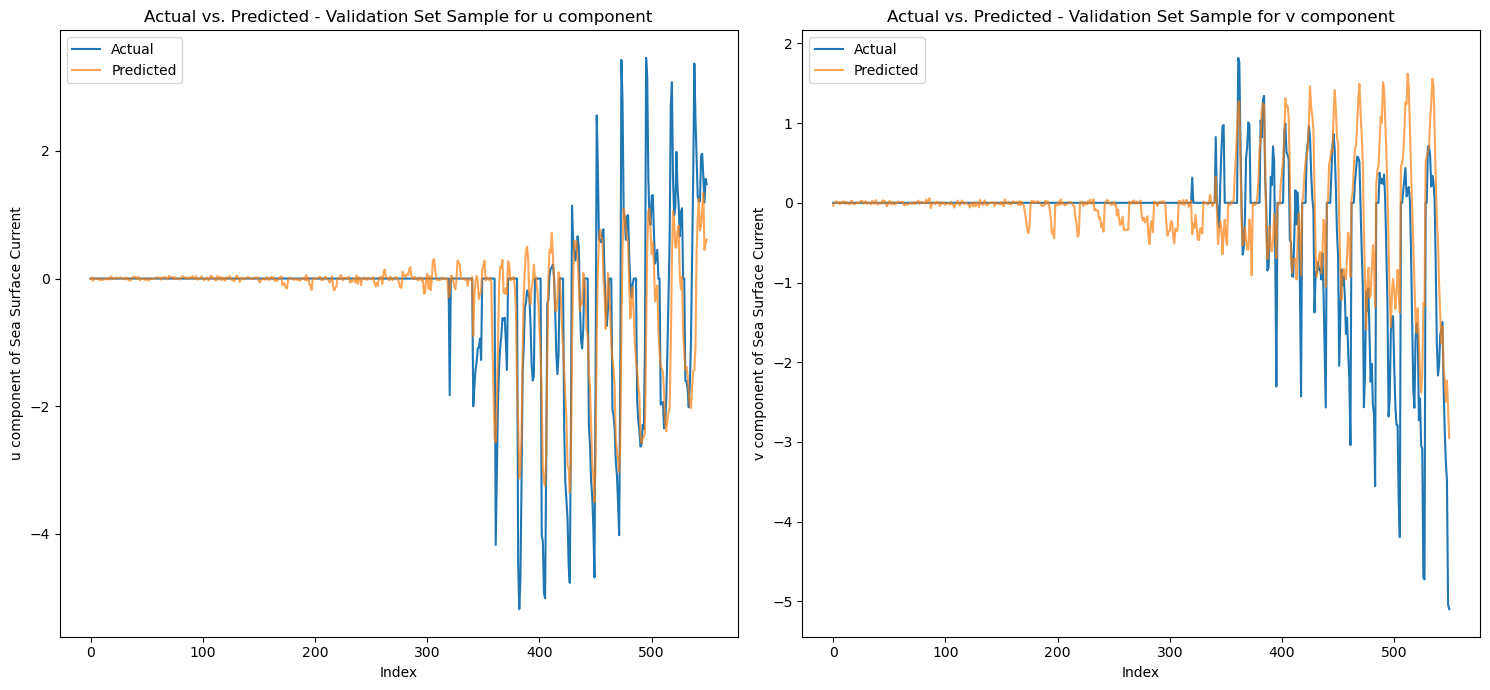

Plots for Test Set:


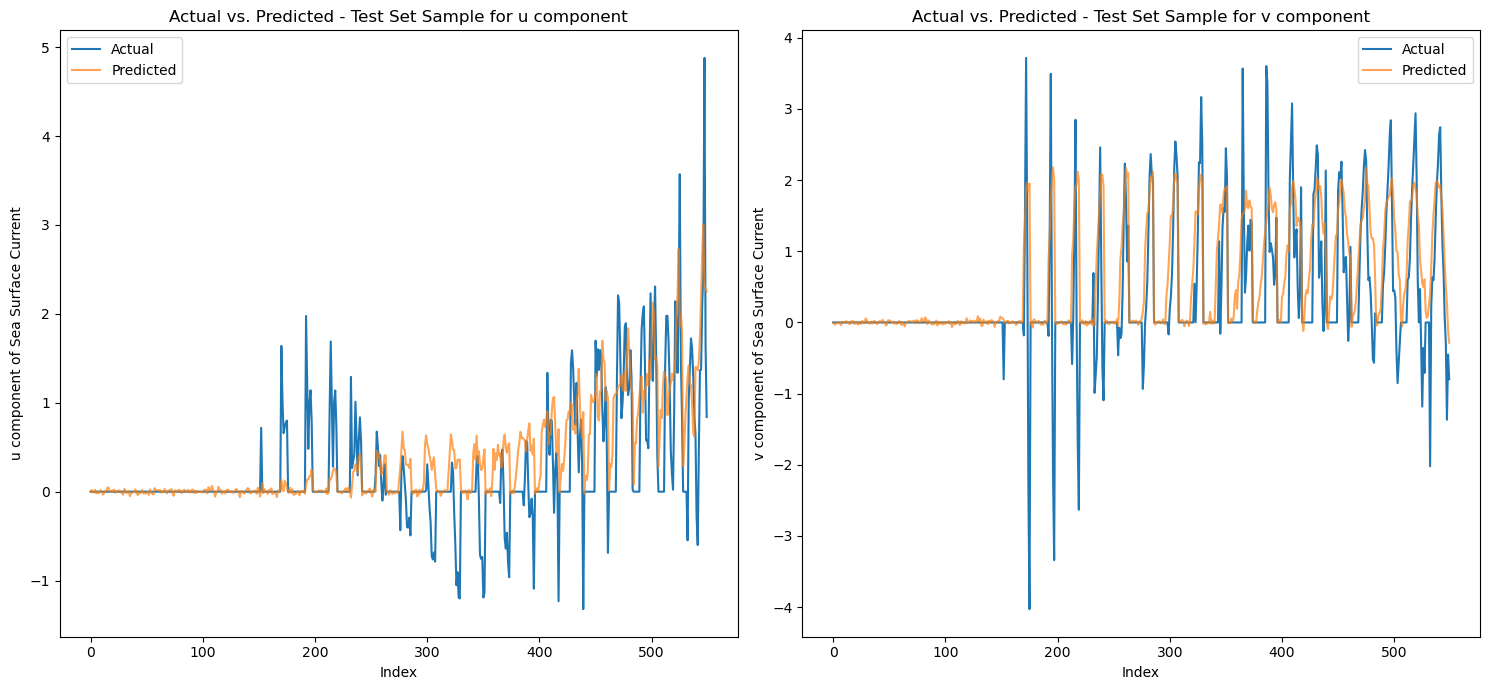

In [33]:
print("Plots for Validation Set:")

# Example: Visualizing the Actual vs. Predicted 'u' and 'v' components for the first sample in the validation set
plt.figure(figsize=(15, 7))

# Plot 'u' component
plt.subplot(1, 2, 1)
plt.plot(y_val[0, :, :, 0].flatten(), label='Actual')
plt.plot(val_predictions[0, :, :, 0].flatten(), label='Predicted', alpha=0.7)
plt.title('Actual vs. Predicted - Validation Set Sample for u component')
plt.xlabel('Index')
plt.ylabel('u component of Sea Surface Current')
plt.legend()

# Plot 'v' component
plt.subplot(1, 2, 2)
plt.plot(y_val[0, :, :, 1].flatten(), label='Actual')
plt.plot(val_predictions[0, :, :, 1].flatten(), label='Predicted', alpha=0.7)
plt.title('Actual vs. Predicted - Validation Set Sample for v component')
plt.xlabel('Index')
plt.ylabel('v component of Sea Surface Current')
plt.legend()

plt.tight_layout()
plt.show()

print("="*125)
print("Plots for Test Set:")

# Example: Visualizing the Actual vs. Predicted 'u' component for the first sample in the test set
plt.figure(figsize=(15, 7))

# Plot 'u' component
plt.subplot(1, 2, 1)
plt.plot(y_test[0, :, :, 0].flatten(), label='Actual')
plt.plot(test_predictions[0, :, :, 0].flatten(), label='Predicted', alpha=0.7)
plt.title('Actual vs. Predicted - Test Set Sample for u component')
plt.xlabel('Index')
plt.ylabel('u component of Sea Surface Current')
plt.legend()

# Plot 'v' component
plt.subplot(1, 2, 2)
plt.plot(y_test[0, :, :, 1].flatten(), label='Actual')
plt.plot(test_predictions[0, :, :, 1].flatten(), label='Predicted', alpha=0.7)
plt.title('Actual vs. Predicted - Test Set Sample for v component')
plt.xlabel('Index')
plt.ylabel('v component of Sea Surface Current')
plt.legend()

plt.tight_layout()
plt.show()

print("="*125)


### Exporting Predictions

In [19]:
# Use the last sequence from the test set as the starting point for rolling predictions
X_initial = X_test[-1]

# Collect predictions in a list
predictions = []

for step in range(56):  # 28 days * 2 predictions per day
    # Make a prediction for the next 12 hours
    next_prediction = model.predict(X_initial.reshape(1, 28, 25, 22, 2), verbose=0)
    
    # Store the prediction
    predictions.append(next_prediction[0])  # next_prediction[0] to get the single prediction from batch
    
    # Update the current sequence with the new prediction
    X_initial = np.roll(X_initial, -1, axis=0)
    X_initial[-1] = next_prediction[0]  # Update with the predicted values for the next time step

# Convert predictions to a numpy array
predictions = np.array(predictions)

# Extract coordinates from the original dataset
time_data = ssc_ds.coords['time'][-len(predictions):].values
lat_data = ssc_ds.coords['lat'].values
lon_data = ssc_ds.coords['lon'].values

# Create a new xarray Dataset
predicted_dataset = xr.Dataset(
    {
        "u": (["time", "lat", "lon"], predictions[:, :, :, 0]),
        "v": (["time", "lat", "lon"], predictions[:, :, :, 1])
    },
    coords={
        "time": time_data,  
        "lat": lat_data,    
        "lon": lon_data     
    }
)

# Export to NetCDF
predicted_dataset.to_netcdf("Model_Outputs/predicted_ssc_data.nc")